### Initial Setup and Data Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


df = pd.read_csv("/Volumes/Personal/DS_Code Alpha/Feature-Engineering-Rolling-Stats/predictive_maintenance.csv")


In [29]:
# Checking dataset info and missing values
df.info()
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque

### Handle Missing Values

In [ ]:
def handle_missing_values(df, numeric_strategy='mean', categorical_strategy='most_frequent'):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    

    numeric_imputer = SimpleImputer(strategy=numeric_strategy)
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    

    categorical_imputer = SimpleImputer(strategy=categorical_strategy)
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    
    return df


df = handle_missing_values(df)


### Dropping Irrelevant Columns

In [31]:
columns_to_drop = ['UDI', 'Product ID']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(existing_columns_to_drop, axis=1, inplace=True)


In [32]:
# Encoding categorical columns using LabelEncoder
le_type = LabelEncoder()
df['Type'] = le_type.fit_transform(df['Type'])

le_failure = LabelEncoder()
df['Failure Type'] = le_failure.fit_transform(df['Failure Type'])


### Plot Feature Distributions Before Feature Engineering

<Figure size 3200x2000 with 0 Axes>

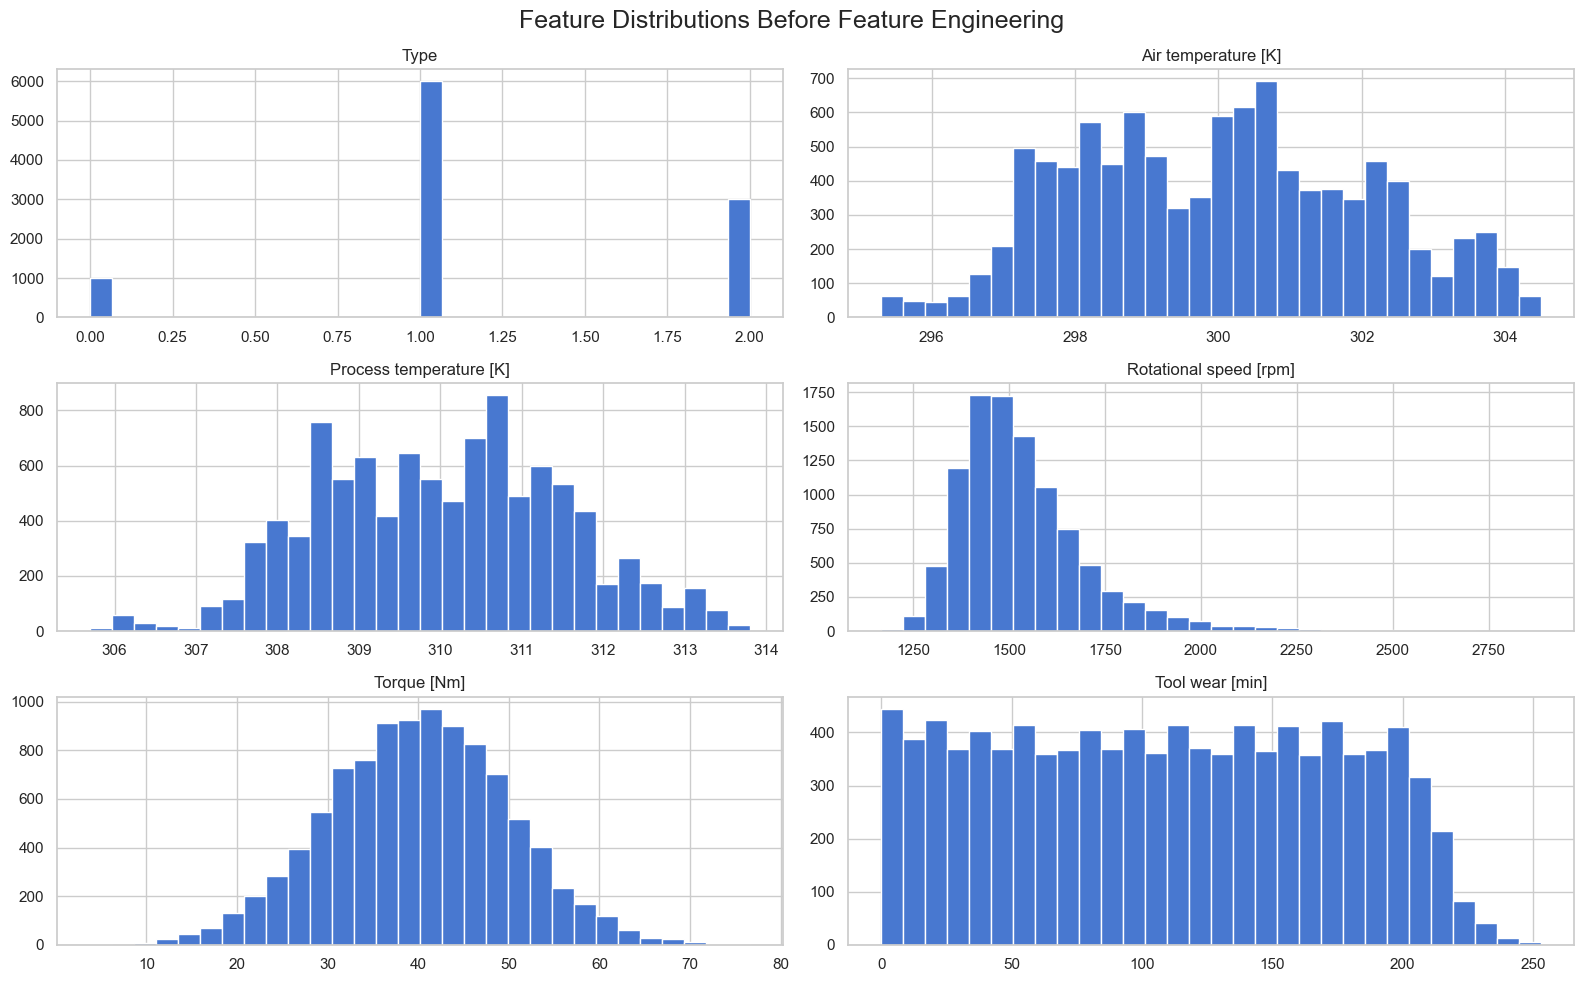

In [33]:
plt.figure(figsize=(16, 10), dpi=200) 
sns.set(style="whitegrid", palette="muted")  
df.drop(['Target', 'Failure Type'], axis=1).hist(bins=30, figsize=(16, 10))
plt.suptitle("Feature Distributions Before Feature Engineering", fontsize=18)
plt.tight_layout()
plt.show()


In [34]:
# feature matrix (X) and target variable (y)
X_base_no_fe = df.drop(['Target', 'Failure Type'], axis=1, errors='ignore')  # Exclude target and failure type
y = df['Target']


In [35]:
# Spliting data into train and test sets (80% train, 20% test)
X_train_no_fe, X_test_no_fe, y_train_no_fe, y_test_no_fe = train_test_split(X_base_no_fe, y, test_size=0.2, random_state=42)


### Training GradientBoosting Model Before Feature Engineering

In [36]:
# Instantiate and train GradientBoosting model
gb_model_no_fe = GradientBoostingClassifier(random_state=42)
gb_model_no_fe.fit(X_train_no_fe, y_train_no_fe)

# Make predictions
y_pred_no_fe = gb_model_no_fe.predict(X_test_no_fe)

# Evaluate model before feature engineering
print("=== Model Evaluation Before Feature Engineering (Gradient Boosting) ===")
print(confusion_matrix(y_test_no_fe, y_pred_no_fe))
print(classification_report(y_test_no_fe, y_pred_no_fe))
print("ROC AUC (Before Feature Engineering):", roc_auc_score(y_test_no_fe, y_pred_no_fe))


=== Model Evaluation Before Feature Engineering (Gradient Boosting) ===
[[1930    9]
 [  23   38]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1939
         1.0       0.81      0.62      0.70        61

    accuracy                           0.98      2000
   macro avg       0.90      0.81      0.85      2000
weighted avg       0.98      0.98      0.98      2000

ROC AUC (Before Feature Engineering): 0.809154625926834


### Feature Engineering (Rolling Mean, Lag Features, and Interactions)

In [37]:
df_fe = df.copy()

# Rolling Mean and Standard Deviation for selected features
rolling_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
for col in rolling_cols:
    df_fe[f'{col}_rolling_mean_5'] = df_fe[col].rolling(window=5).mean()
    df_fe[f'{col}_rolling_std_5'] = df_fe[col].rolling(window=5).std()

# Lag Features
for col in rolling_cols:
    df_fe[f'{col}_lag_1'] = df_fe[col].shift(1)
    df_fe[f'{col}_lag_2'] = df_fe[col].shift(2)

# Domain-specific interaction features
df_fe['temp_diff'] = df_fe['Process temperature [K]'] - df_fe['Air temperature [K]']
df_fe['speed_torque_ratio'] = df_fe['Rotational speed [rpm]'] / (df_fe['Torque [Nm]'] + 1e-3)

# Droping rows with NaNs from rolling/lag features
df_fe = df_fe.dropna()


df_fe.to_csv('/Volumes/Personal/DS_Code Alpha/Feature-Engineering-Rolling-Stats/predictive_maintenance_with_fe.csv', index=False)


In [38]:
# Cleaning column names by replacing non-alphanumeric characters with an underscore
df_fe.columns = df_fe.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)


In [39]:
# Defining feature matrix (X) and target variable (y) after feature engineering
X_eng = df_fe.drop(['Target', 'Failure Type'], axis=1, errors='ignore')
y_eng = df_fe['Target']


In [40]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)


### Training GradientBoosting Model After Feature Engineering

In [41]:
# Instantiate and train GradientBoosting model with feature-engineered data
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_eng, y_train_eng)

# Make predictions
y_pred = gb_model.predict(X_test_eng)

# Evaluate model after feature engineering
print("=== Model Evaluation After Feature Engineering (Gradient Boosting) ===")
print(confusion_matrix(y_test_eng, y_pred))
print(classification_report(y_test_eng, y_pred))
print("ROC AUC (After Feature Engineering):", roc_auc_score(y_test_eng, y_pred))


=== Model Evaluation After Feature Engineering (Gradient Boosting) ===
[[1928    2]
 [   2   68]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1930
         1.0       0.97      0.97      0.97        70

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC (After Feature Engineering): 0.9851961509992598


### ROC AUC Scores (Before vs After Feature Engineering)

/var/folders/1c/wgg3jchj1vnb_c49fv64srjm0000gn/T/ipykernel_10097/3277067933.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels, y=roc_auc_scores, palette=colors, width=0.5)


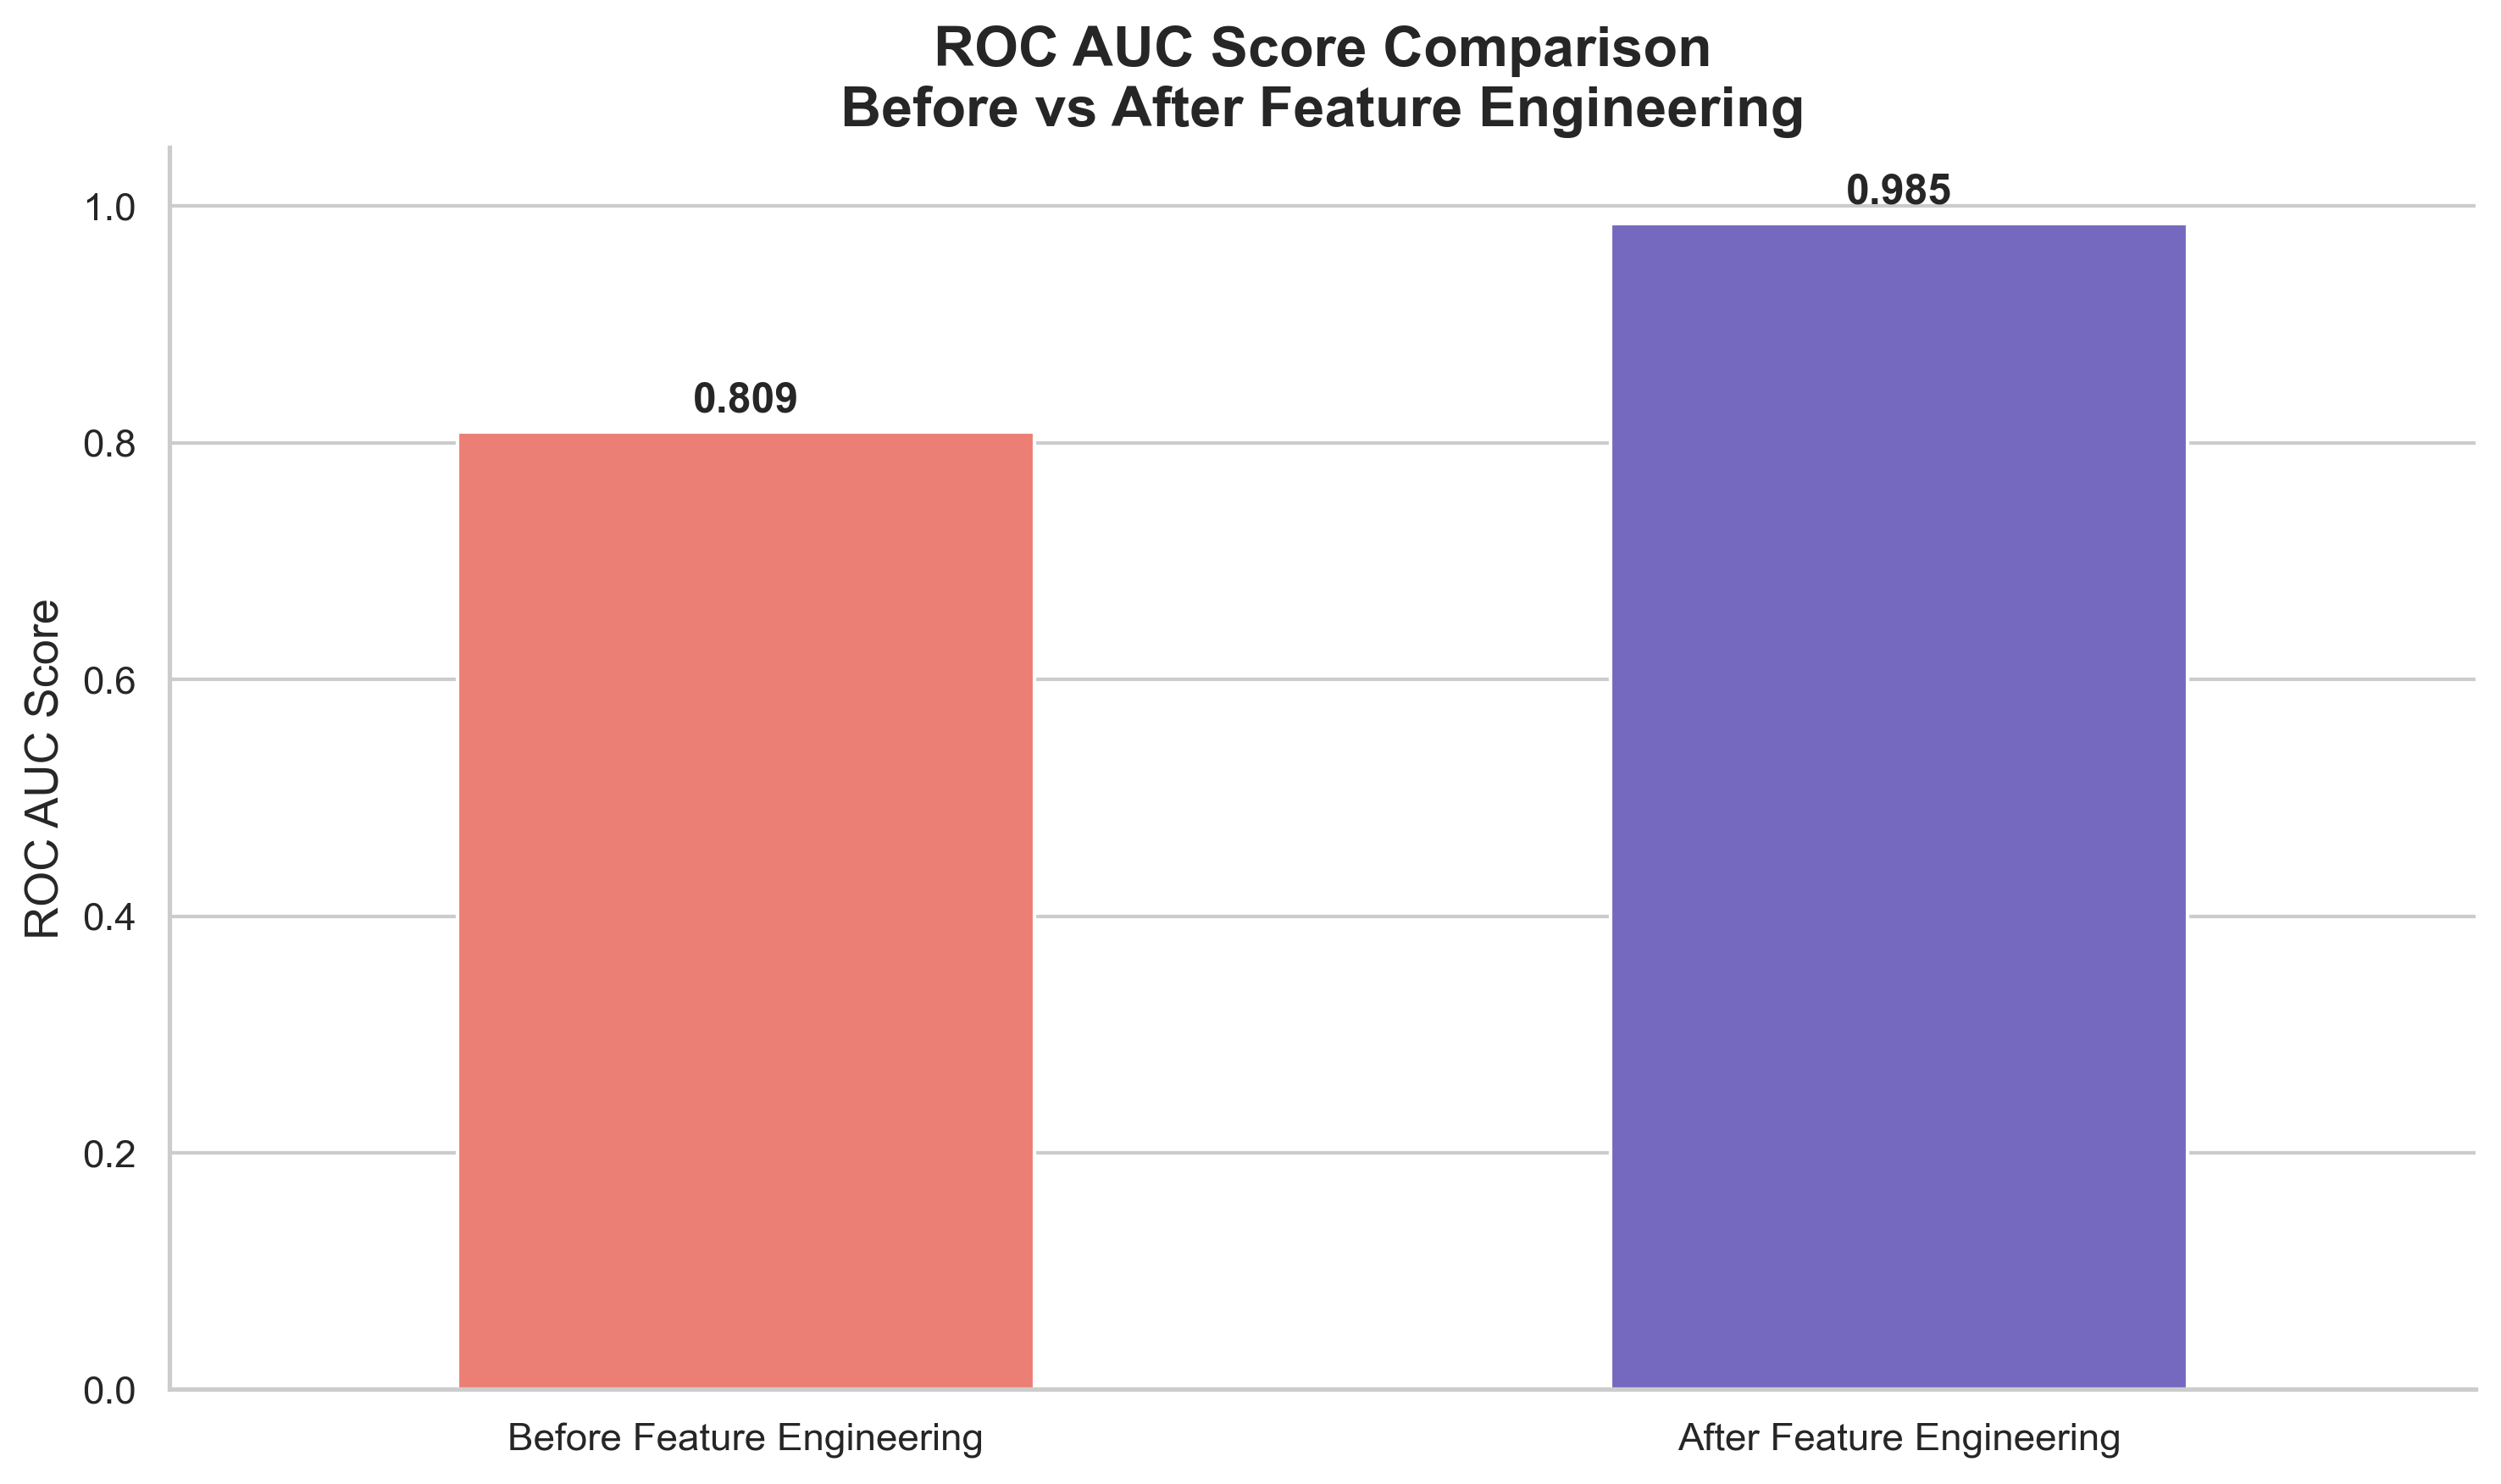

In [42]:
# Calculate ROC AUC scores before and after feature engineering
roc_auc_no_fe = roc_auc_score(y_test_no_fe, y_pred_no_fe)  # ROC AUC before feature engineering
roc_auc_with_fe = roc_auc_score(y_test_eng, y_pred)  # ROC AUC after feature engineering



# Plot ROC AUC Scores Comparison
labels = ['Before Feature Engineering', 'After Feature Engineering']
roc_auc_scores = [roc_auc_no_fe, roc_auc_with_fe]


# Define the colors for the bar plot
colors = ['#ff6f61', '#6a5acd']  # muted coral and slate blue

# Create the figure
plt.figure(figsize=(10, 6), dpi=300)

# Set the bar plot width to 0.5 (adjust this value to control the bar width)
barplot = sns.barplot(x=labels, y=roc_auc_scores, palette=colors, width=0.5)

# Annotate bars with scores
for index, value in enumerate(roc_auc_scores):
    plt.text(index, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Title and labels
plt.title('ROC AUC Score Comparison\nBefore vs After Feature Engineering', fontsize=16, fontweight='bold')
plt.ylabel('ROC AUC Score', fontsize=13)
plt.xlabel('')
plt.ylim(0, 1.05)

# Remove top and right spines
sns.despine()

# Make layout tight and clean
plt.tight_layout()
plt.show()


###  Model Validation Pipeline



### Train-Test Split (Time-Based)

In [43]:
X = df_fe.drop(['Target'], axis=1)
y = df_fe['Target']

# Time-based split
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


### Model Performance Validation with TimeSeriesSplit

In [44]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

tscv = TimeSeriesSplit(n_splits=5)
model = GradientBoostingClassifier(random_state=42)

cv_scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
print("TimeSeries CV AUC scores:", cv_scores)
print("Mean AUC:", cv_scores.mean())


TimeSeries CV AUC scores: [0.97075043 0.99643827 0.96926551 0.9993865  0.97011743]
Mean AUC: 0.981191628948537


### Target Drift / Class Distribution Check

In [45]:
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train target distribution:
 Target
0.0    0.962481
1.0    0.037519
Name: proportion, dtype: float64
Test target distribution:
 Target
0.0    0.9805
1.0    0.0195
Name: proportion, dtype: float64
